In [1]:
# O dataset pode ser baixado nessa URL, tem um arquivo zip com tudo ali dentro: https://github.com/matterport/Mask_RCNN/releases

# Na função built-in add_class(), precisamos informar o nome do dataset, o número da classe (1 para balloon, 
# 0 é reservado para background), e o nome da classe (nesse caso, 1 é o número e 'balloon' é o nome).
# Resumindo: add_class('dataset_name', 1, 'balloon')

# O dataset já está dividido em treino e teste, basta coletarmos os dados do diretório correto em cada caso.

# Criando a função que carrega o dataset:
def carrega_dataset(self, endereco_dataset, subset):
    # endereco_dataset é o diretório raiz do dataset
    # subset poderá assumir os valores 'train' ou 'val' (treino ou teste)

    self.add_class("balloon", 1, "balloon") # aplica a função built-in add_class()

    # Escolhendo o diretório a partir do subset treino ou teste:
    assert subset in ["train", "val"] # assert testa uma condição. Se a condição é verdadeira, continua o código. Se a condição é falsa, traz uma mensagem de erro.
    endereco_dataset = os.path.join(endereco_dataset, subset) # adiciona o diretório correto dependendo se for train ou val

    # Carregando as anotações:
    # O programa VGG Image Annotator salva cada imagem em um formato semelhante a um dicionário:
    # Existem algumas chaves com valores vazios, e outras chaves com conteúdo, por exemplo:
    # { 'filename': '28503151_5b5b7ec140_b.jpg', # possui conteúdo
    #  "base64_img_data":"",  # vazio, e assim por diante...abaixo seguem mais exemplos informações que aparecem:
    #   'regions': {
    #       '0': {
    #           'region_attributes': {},
    #           'shape_attributes': {
    #               'all_points_x': [...],
    #               'all_points_y': [...],
    #               'name': 'polygon'}},
    #       ... more regions ...
    #   },
    #   'size': 100202
    # }
    # Basicamente, temos dicionários dentro de dicionários
    # Nós estamos interessados nas coordenadas x e y de cada região, portanto vamos coletar isso:
    anotacoes = json.load(open(os.path.join(endereco_dataset, "via_region_data.json"))) # carrega as anotações json
    anotacoes = list(anotacoes.values())  # pega somente os valores da primeira chave do dicionário. '{'34020010494_e5cb88e1c4_k.jpg1115004'...' cai, fica:[{'fileref': '',...

    # O programa VGG Image Annotator salva imagens mesmo que elas não tenham nenhuma anotação, então vamos pular
    # imagens que eventualmente não possuem anotações:
    anotacoes = [a for a in anotacoes if a['regions']] #se existe a chave 'regions', salva na lista

    # Adicionando as imagens:
    for a in anotacoes:
        # Coletando as coordenadas x e y de dentro de shape_attributes (essas coordenadas definem as máscaras):
        poligonos = [r['shape_attributes'] for r in a['regions'].values()] # 'shape_attributes' é um dos valores da chave 'regions'

        # A função load_mask() pede o tamanho da imagem também, não apenas as máscaras. Mas o programa VGG Image 
        # não inclui essa informação no JSON, então precisamos coletar essa informação direto das imagens.
        endereco_imagem = os.path.join(endereco_dataset, a['filename']) # une o nome do arquivo com o diretório atual
        imagem = skimage.io.imread(endereco_imagem) # lê a imagem
        altura, largura = imagem.shape[:2] # pega das dimensões
        
        # Agora vamos aplicar a função built-in add_image(), que precisa receber o nome do dataset, nome do arquivo
        # e o diretório que esse arquivo está:
        self.add_image("balloon", image_id=a['filename'], path=endereco_imagem, width=largura, height=altura, polygons=poligonos) # passa as anotações (atributos extras), em 3 variáveis: width, height e polygons

In [2]:
# Criando a função que carrega a máscara de uma imagem específica:
def load_mask(self, imagem_id):
    
    # Convertendo polígonos em máscaras de shape [height, width, quantidade_mascaras]:
    informacoes = self.image_info[imagem_id] # recupera todas as informações passadas para add_image() 
    mascara = np.zeros([informacoes["height"], informacoes["width"], len(informacoes["polygons"])], dtype=np.uint8) # cria máscaras do tamanho das imagens e preenche com zeros
    for i, p in enumerate(informacoes["polygons"]): # para cada ponto x, y salvo em polygons
        rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x']) # coleta os pontos das coordenadas x e y
        mascara[rr, cc, i] = 1 # preenche com 1's toda a área coberta pelos pontos das coordenadas x e y

    return mascara, np.ones([mascara.shape[-1]], dtype=np.int32) # retorna a máscara, e a classe (em um array int32)
    # como todos os objetos da máscara possuem classe 1, passamos um array de 1's do tamanho referente à quantidade de máscaras

In [3]:
# Criando uma classe de configurações básicas
class ConfiguracoesBaloes(Config):
    NAME = "baloes" # atribui um nome para a configuração
    IMAGES_PER_GPU = 2 # quantas imagens serão passadas para a GPU de cada vez
    NUM_CLASSES = 2  # define o número de classes (background + baloon)
    STEPS_PER_EPOCH = 100 # define o número de passadas por epoch 
    
config = ConfiguracoesBaloes()

# Criando o modelo:
modelo = MaskRCNN(mode='training', model_dir='C:/Users/Matheus/Desktop/Matheus/Programming/Python/MachineLearning/Module3/04-ComputerVision/Models', config=config) # Em model_dir, informamos onde o modelo treinado será salvo. Em mode, podemos informar se é 'training' ou 'inference'
modelo.load_weights('/home/natanael/Documents/DidaticaTech/kangaroo/mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"]) # carregando pesos de um modelo já treinado, excluindo algumas camadas/layers inúteis para nosso caso
modelo.train(dataset_treino, dataset_teste, learning_rate=0.001, epochs=5, layers='heads')

NameError: name 'Config' is not defined

In [36]:
# Implementando tudo que fizemos até aqui em um único código:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
from mrcnn.config import Config
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN

class DatasetBaloes(Dataset):

    def carrega_dataset(self, endereco_dataset, subset):
        self.add_class("balloon", 1, "balloon") 
    
        assert subset in ["train", "val"] 
        endereco_dataset = os.path.join(endereco_dataset, subset)

        anotacoes = json.load(open(os.path.join(endereco_dataset, "via_region_data.json"))) 
        anotacoes = list(anotacoes.values())  

        anotacoes = [a for a in anotacoes if a['regions']] 

        for a in anotacoes:
        
            poligonos = [r['shape_attributes'] for r in a['regions'].values()] 

            endereco_imagem = os.path.join(endereco_dataset, a['filename']) 
            imagem = skimage.io.imread(endereco_imagem)
            altura, largura = imagem.shape[:2] 

            self.add_image("balloon", image_id=a['filename'], path=endereco_imagem, width=largura, height=altura, polygons=poligonos)
        
    def load_mask(self, imagem_id):
        
        informacoes = self.image_info[imagem_id] 
        mascara = np.zeros([informacoes["height"], informacoes["width"], len(informacoes["polygons"])], dtype=np.uint8)
        for i, p in enumerate(informacoes["polygons"]): 
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x']) 
            mascara[rr, cc, i] = 1 

        return mascara, np.ones([mascara.shape[-1]], dtype=np.int32)


class ConfiguracoesBaloes(Config):
    NAME = "baloes" 
    IMAGES_PER_GPU = 2 
    NUM_CLASSES = 2  
    STEPS_PER_EPOCH = 100 
    
config = ConfiguracoesBaloes()

In [37]:
# Verificando algumas informações e testando o código completo

dataset = DatasetBaloes() # instancia a classe criada
dataset.carrega_dataset('/home/natanael/Documents/DidaticaTech/balloon_dataset/balloon', "train") # carrega o dataset de treino
dataset.prepare() # prepara o dataset

print("Total de imagens: {}".format(len(dataset.image_ids))) # imprime a quantidade de imagens
print("Total de classes: {}".format(dataset.num_classes)) # imprime a quantidade de classes

FileNotFoundError: [Errno 2] No such file or directory: '/home/natanael/Documents/DidaticaTech/balloon_dataset/balloon\\train\\via_region_data.json'

In [38]:
# Mostrando algumas imagens e suas máscaras
from mrcnn import visualize

ids_imagens = [0, 1, 2, 3] # escolhe algumas imagens específicas
for imagem_id in ids_imagens: # para cada uma dessas imagens
    imagem = dataset.load_image(imagem_id) # carrega a imagem
    mascara, ids_classes = dataset.load_mask(imagem_id) # coleta a máscara e a classe da imagem
    visualize.display_top_masks(imagem, mascara, ids_classes, dataset.class_names) # mostra na tela a imagem original e sua máscara

IndexError: list index out of range

In [ ]:
# Mostrando as caixas (bounding boxes) com a respectiva classe escrita na caixa
# Iremos coletar as caixas diretamente das máscaras
from mrcnn import utils
from mrcnn.model import log

imagem_id = 2 # escolhe uma imagem específica
imagem = dataset.load_image(imagem_id) # carrega essa imagem
mascara, ids_classes = dataset.load_mask(imagem_id) # coleta a máscara e a classe da imagem
caixas = utils.extract_bboxes(mascara) # extrai as caixas a partir da máscara

visualize.display_instances(imagem, caixas, mascara, ids_classes, dataset.class_names) # mostra a imagem com sua bounding box

In [5]:
# Calculando a performance do modelo
# IoU (Intersection over Union) é a fórmula: (área sobreposta)/(área total), onde área total é a soma das áreas de 
# ambas as caixas. Quando IoU > 0.5, é considerado que o modelo está bom. 
# Para verificar a performance do modelo, vamos calcular o IoU de cada imagem de teste e ver se está acima de 0.5.
# A taxa de sucessos (imagens com IoU > 0.5/ total_imagens) é chamada de Average Precision (AP).

from numpy import expand_dims
from numpy import mean
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

# Essa primeira parte do código é igual ao que já utilizamos:
class DatasetBaloes(Dataset):

    def carrega_dataset(self, endereco_dataset, subset):
        self.add_class("balloon", 1, "balloon") 
    
        assert subset in ["train", "val"] 
        endereco_dataset = os.path.join(endereco_dataset, subset)

        anotacoes = json.load(open(os.path.join(endereco_dataset, "via_region_data.json"))) 
        anotacoes = list(anotacoes.values())  

        anotacoes = [a for a in anotacoes if a['regions']] 

        for a in anotacoes:
        
            poligonos = [r['shape_attributes'] for r in a['regions'].values()] 

            endereco_imagem = os.path.join(endereco_dataset, a['filename']) 
            imagem = skimage.io.imread(endereco_imagem)
            altura, largura = imagem.shape[:2] 

            self.add_image("balloon", image_id=a['filename'], path=endereco_imagem, width=largura, height=altura,
                polygons=poligonos)
        
    def load_mask(self, imagem_id):
    
        informacoes = self.image_info[imagem_id] 
        mascara = np.zeros([informacoes["height"], informacoes["width"], len(informacoes["polygons"])], dtype=np.uint8)
        for i, p in enumerate(informacoes["polygons"]): 
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x']) 
            mascara[rr, cc, i] = 1 

        return mascara, np.ones([mascara.shape[-1]], dtype=np.int32)

# Criando uma classe para as configurações das previsões:
class ConfiguracoesPrevisoes(Config): 
    NAME = "dataset_baloes"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
# Criando uma função para calcular o AP:
def avalia_modelo(dataset, modelo, cfg):
    APs = []
    for imagem_id in dataset.image_ids:
        # Extraindo cada imagem, sua caixa e sua máscara:
        dim_imagem, dim_image_bruta, id_classe_gt, dim_caixas_gt, mascara_gt = load_image_gt(dataset, cfg, imagem_id, use_mini_mask=False) #mini_mask é um parâmetro pra diminuir o tamanho da máscara (caso existam máscaras muito grandes)
        # dim_imagem e dim_image_bruta são as dimensões atuais da imagem e suas dimensões antes de redimensionar e cortar
        # Agora vamos subtrair todos os pixels da imagem pelo valor do pixel médio. Isso se chama "centering",  
        # é uma prática comum no pré-processamento de imagens, pois coloca a distribuição dos valores dos pixels
        # centrada em zero (isso facilita a sensibilidade do aprendizado na CNN):
        imagem_centrada = mold_image(dim_imagem, cfg)
        # Quando estamos treinando o modelo, estamos passando as imagens em batches para um placeholder. Ou seja, 
        # a dimensão de entrada é não apenas a dimensão das imagens, mas também tem uma dimensão que informa a 
        # quantidade de imagens. No treino era assim: [batch_size, img_width, img_height, number_of_channels]
        # Na hora de fazer previsões, precisamos fazer o mesmo. Então se queremos passar uma imagem de cada vez,
        # precisamos mesmo assim criar uma dimensão que diga que há somente uma imagem nesse lote. 
        # Isso se consegue facilmente com a função expand_dims() do numpy. 
        # Exemplo: a imagem atual possui o formato [img_width, img_height, number_of_channels]
        # Usando expand_dims(image, axis=0), teremos: [1, img_width, img_height, number_of_channels]
        amostra = expand_dims(imagem_centrada, 0)
        # Fazendo as previsões:
        coleta_infos = modelo.detect(amostra, verbose=0) # a função detect() retorna as caixas, a classe, o score da classe e a máscara.
        # A saída da função detect() é uma lista de dicionários. Vamos coletar os dados do dicionário recém criado:
        dados = coleta_infos[0]
        # Usando a função built-in que calcula o AP:
        AP, _, _, _ = compute_ap(dim_caixas_gt, id_classe_gt, mascara_gt, dados["rois"], dados["class_ids"], dados["scores"], dados['masks'], iou_threshold=0.5)
        # Para a função acima, estamos passando uma imagem de cada vez, então podemos armazenar isso:
        APs.append(AP)
    # Agora que todos os valores foram armazenados, vamos calcular a média total:
    media_AP = mean(APs)
    return media_AP
 
# Criando o dataset de treino
dataset_treino = DatasetBaloes()
dataset_treino.carrega_dataset('/home/natanael/Documents/DidaticaTech/balloon_dataset/balloon', "train")
dataset_treino.prepare()
print('Tamanho treino: %d' % len(dataset_treino.image_ids))

# Criando o dataset de teste
dataset_teste = DatasetBaloes()
dataset_teste.carrega_dataset('/home/natanael/Documents/DidaticaTech/balloon_dataset/balloon', "val")
dataset_teste.prepare()
print('Tamanho teste %d' % len(dataset_teste.image_ids))

cfg = ConfiguracoesPrevisoes()

modelo = MaskRCNN(mode='inference', model_dir='/home/natanael/Documents/DidaticaTech/balloon_dataset/modelo_testando', config=cfg)
# Carregando os dados do modelo já treinado:
modelo.load_weights('/home/natanael/Documents/DidaticaTech/balloon_dataset/treinando_modelo/baloes20200201T1003/mask_rcnn_baloes_0005.h5', by_name=True)
# Avaliando a performance nos dados de treino:
media_AP_treino = avalia_modelo(dataset_treino, modelo, cfg)
print("Média AP total dataset_treino: %.3f" % media_AP_treino)
# Avaliando a performance nos dados de teste:
media_AP_teste = avalia_modelo(dataset_teste, modelo, cfg)
print("Média AP total dataset_teste: %.3f" % media_AP_teste)

Tamanho treino: 61
Tamanho teste 13
Re-starting from epoch 5
Média AP total dataset_treino: 0.932
Média AP total dataset_teste: 0.790


Tamanho treino: 61
Tamanho teste 13
Re-starting from epoch 5


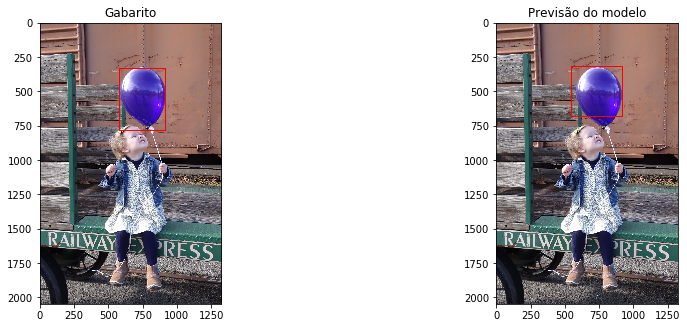

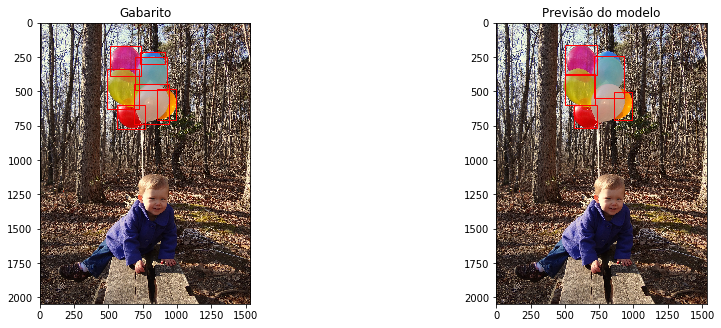

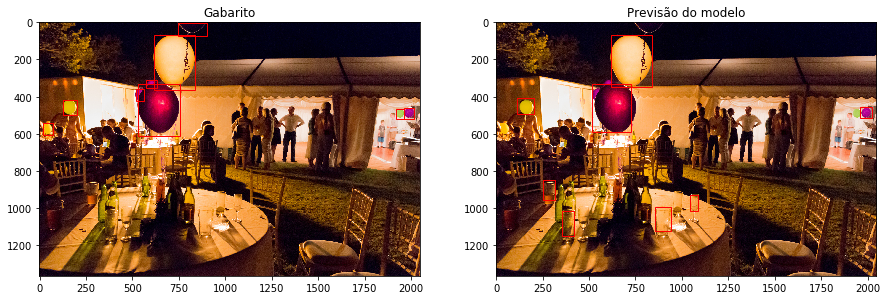

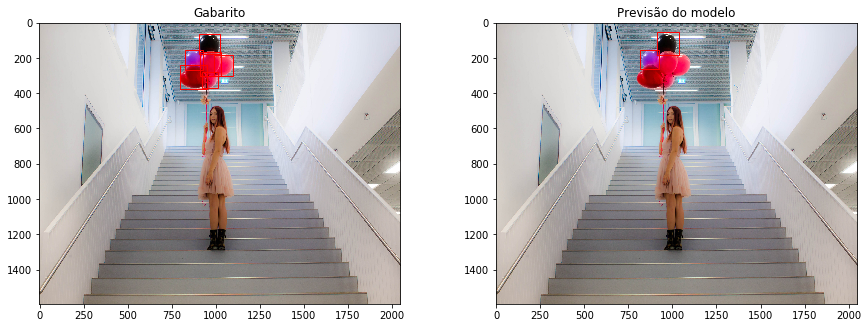

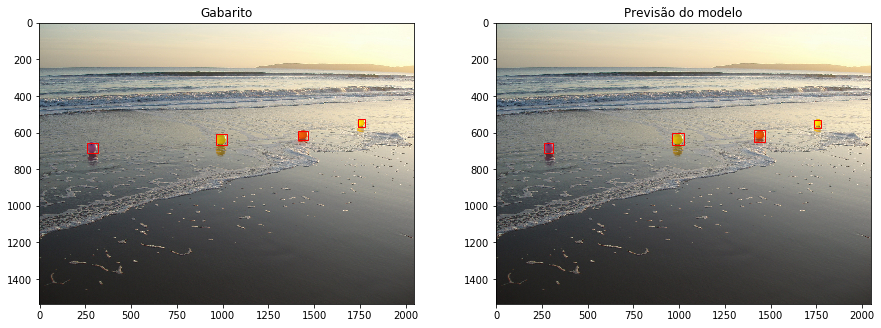

In [6]:
# Mostrando a detecção de balões com caixas

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import figure
from mrcnn import utils

# Essa primeira parte do código é igual ao que já utilizamos
class DatasetBaloes(Dataset):

    def carrega_dataset(self, endereco_dataset, subset):
        self.add_class("balloon", 1, "balloon") 
    
        assert subset in ["train", "val"] 
        endereco_dataset = os.path.join(endereco_dataset, subset)

        anotacoes = json.load(open(os.path.join(endereco_dataset, "via_region_data.json"))) 
        anotacoes = list(anotacoes.values())  

        anotacoes = [a for a in anotacoes if a['regions']] 

        for a in anotacoes:
        
            poligonos = [r['shape_attributes'] for r in a['regions'].values()] 

            endereco_imagem = os.path.join(endereco_dataset, a['filename']) 
            imagem = skimage.io.imread(endereco_imagem)
            altura, largura = imagem.shape[:2] 

            self.add_image("balloon", image_id=a['filename'], path=endereco_imagem, width=largura, height=altura, polygons=poligonos)
        
    def load_mask(self, imagem_id):

        informacoes = self.image_info[imagem_id] 
        mascara = np.zeros([informacoes["height"], informacoes["width"], len(informacoes["polygons"])], dtype=np.uint8)
        for i, p in enumerate(informacoes["polygons"]): 
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x']) 
            mascara[rr, cc, i] = 1 

        return mascara, np.ones([mascara.shape[-1]], dtype=np.int32)


# Criando uma classe para as configurações das previsões:
class ConfiguracoesPrevisoes(Config): 
    NAME = "dataset_baloes"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# Criando função que mostra n imagens de teste, cada uma com sua caixa real e com a caixa prevista pelo modelo:
def plotando_atual_vs_prevista(dataset, modelo, cfg, n_imagens=5):
    for i in range(n_imagens): # varrendo as primeiras 5 imagens do dataset de teste
        imagem = dataset.load_image(i) # carrega cada imagem
        mascara, _ = dataset.load_mask(i) # carrega cada máscara
        imagem_centrada = mold_image(imagem, cfg) # aplicando centering
        amostra = expand_dims(imagem_centrada, 0) # criando a dimensão extra do batch_size
        dados = modelo.detect(amostra, verbose=0)[0] # fazendo a previsão dessa imagem
        figura = plt.figure(figsize=(15,30)) # tamanho da figura total (terá que comportar 10 imagens nesse caso)
        # Criando primeiro os subplots para mostrar as imagens de teste com suas máscaras reais:
        figura.add_subplot(n_imagens, 2, i*2+1) # quebra as linhas da figura em 5 partes e as colunas em 2 partes. Para cada imagem i, plota ela nos quadrantes da coluna esquerda (quadrantes ímpares)
        plt.imshow(imagem) # mostra a imagem
        plt.title('Gabarito')
        eixos = plt.gca()
        # não iremos plotar as máscaras reais dessa vez, apenas as caixas!
        #for j in range(mascara.shape[2]):
            #plt.imshow(mascara[:, :, j], cmap='gray', alpha=0.3) # desenha a máscara
        for caixa in utils.extract_bboxes(mascara):
            y1, x1, y2, x2 = caixa
            largura, altura = x2 - x1, y2 - y1
            retangulo = Rectangle((x1, y1), largura, altura, fill=False, color='red')
            eixos.add_patch(retangulo)
        
        # Criando os subplots para mostrar as imagens de teste com suas caixas previstas pelo modelo:
        figura.add_subplot(n_imagens, 2, i*2+2) # quebra as linhas da figura em 5 partes e as colunas em 2 partes. Para cada imagem i, plota ela nos quadrantes da coluna direita (quadrantes pares)
        plt.imshow(imagem) # mostra a imagem 
        plt.title('Previsão do modelo')
        eixos = plt.gca() # gca significa "get current axis". Ele seleciona os eixos da figura atual.
        # plotando as caixas previstas:
        for caixa in dados['rois']: # coleta as informações da caixa prevista
            y1, x1, y2, x2 = caixa # coloca cada coordenada da caixa em uma variável
            largura, altura = x2 - x1, y2 - y1 # calcula a espessura e a altura da caixa
            retangulo = Rectangle((x1, y1), largura, altura, fill=False, color='red') # cria um retângulo (caixa)
            eixos.add_patch(retangulo) # adiciona o retângulo criado na figura
    # Resumindo: para cada imagem de teste, mostramos a imagem com sua caixa na esquerda e a imagem com sua caixa
    # prevista pelo modelo na direita.            
    plt.show()

# Criando o dataset de treino
dataset_treino = DatasetBaloes()
dataset_treino.carrega_dataset('/home/natanael/Documents/DidaticaTech/balloon_dataset/balloon', "train")
dataset_treino.prepare()
print('Tamanho treino: %d' % len(dataset_treino.image_ids))

# Criando o dataset de teste
dataset_teste = DatasetBaloes()
dataset_teste.carrega_dataset('/home/natanael/Documents/DidaticaTech/balloon_dataset/balloon', "val")
dataset_teste.prepare()
print('Tamanho teste %d' % len(dataset_teste.image_ids))

cfg = ConfiguracoesPrevisoes()

modelo = MaskRCNN(mode='inference', model_dir='/home/natanael/Documents/DidaticaTech/balloon_dataset/modelo_testando', config=cfg)

# Escolhendo qual modelo treinado utilizar para fazer a detecção de balões:
modelo.load_weights('/home/natanael/Documents/DidaticaTech/balloon_dataset/treinando_modelo/baloes20200201T1003/mask_rcnn_baloes_0005.h5', by_name=True)

# Mostrando as previsões no dataset de teste:
plotando_atual_vs_prevista(dataset_teste, modelo, cfg)

Tamanho treino: 61
Tamanho teste 13
Re-starting from epoch 5


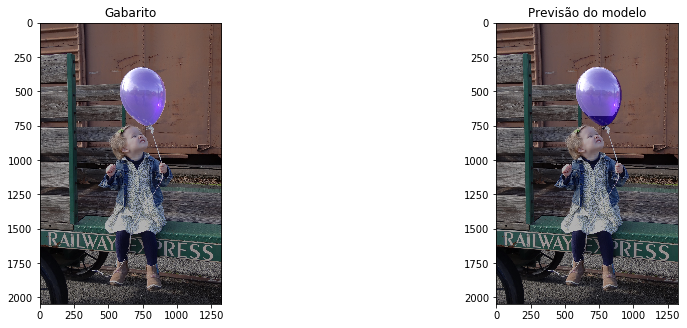

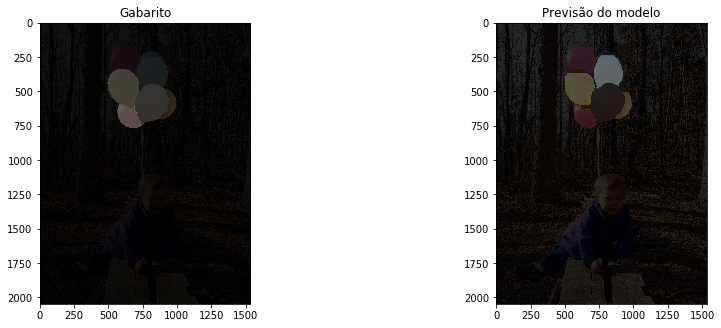

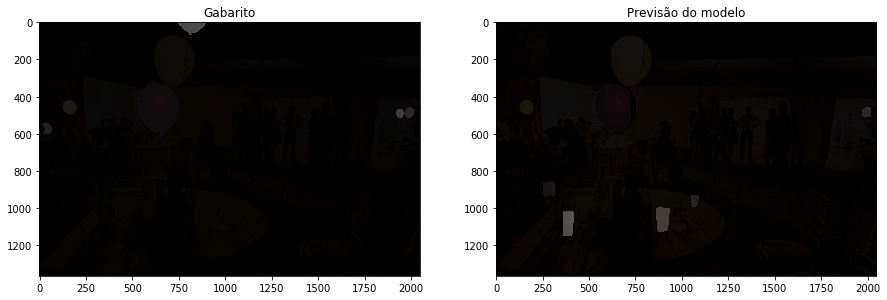

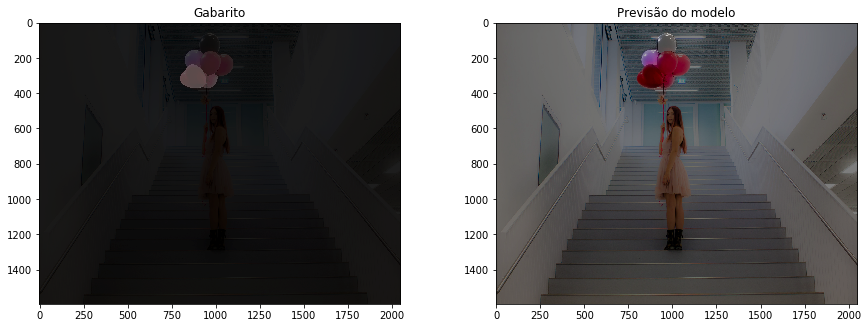

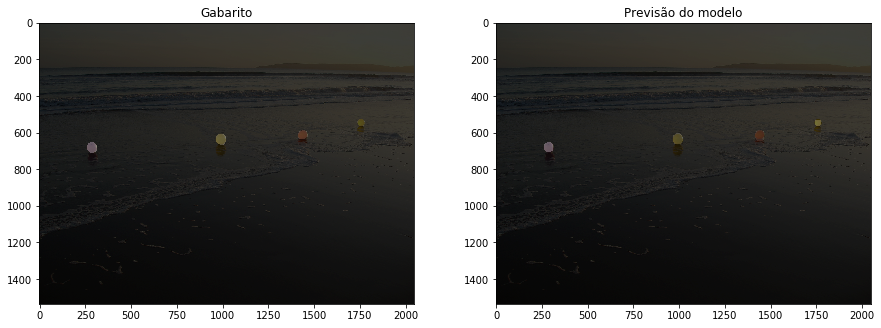

In [7]:
# Mostrando a detecção de balões com máscaras

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.pyplot import figure
from mrcnn import utils

# Essa primeira parte do código é igual ao que já utilizamos
class DatasetBaloes(Dataset):

    def carrega_dataset(self, endereco_dataset, subset):
        self.add_class("balloon", 1, "balloon") 
    
        assert subset in ["train", "val"] 
        endereco_dataset = os.path.join(endereco_dataset, subset)

        anotacoes = json.load(open(os.path.join(endereco_dataset, "via_region_data.json"))) 
        anotacoes = list(anotacoes.values())  

        anotacoes = [a for a in anotacoes if a['regions']] 

        for a in anotacoes:
        
            poligonos = [r['shape_attributes'] for r in a['regions'].values()] 

            endereco_imagem = os.path.join(endereco_dataset, a['filename']) 
            imagem = skimage.io.imread(endereco_imagem)
            altura, largura = imagem.shape[:2] 

            self.add_image("balloon", image_id=a['filename'], path=endereco_imagem, width=largura, height=altura, polygons=poligonos)
        
    def load_mask(self, imagem_id):
    
        informacoes_imagem = self.image_info[imagem_id]

        informacoes = self.image_info[imagem_id] 
        mascara = np.zeros([informacoes["height"], informacoes["width"], len(informacoes["polygons"])], dtype=np.uint8)
        for i, p in enumerate(informacoes["polygons"]): 
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x']) 
            mascara[rr, cc, i] = 1 

        return mascara, np.ones([mascara.shape[-1]], dtype=np.int32)


# Criando uma classe para as configurações das previsões:
class ConfiguracoesPrevisoes(Config): 
    NAME = "dataset_baloes"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# Criando função que mostra n imagens de teste, cada uma com sua máscara real e com a máscara prevista pelo modelo:
def plotando_mascara_atual_vs_prevista(dataset, modelo, cfg, n_imagens=5):
    for i in range(n_imagens): # varrendo as primeiras 5 imagens do dataset de teste
        imagem = dataset.load_image(i) # carrega cada imagem
        mascara, _ = dataset.load_mask(i) # carrega cada máscara
        imagem_centrada = mold_image(imagem, cfg) # aplicando centering
        amostra = expand_dims(imagem_centrada, 0) # criando a dimensão extra do batch_size
        dados = modelo.detect(amostra, verbose=0)[0] # fazendo a previsão dessa imagem
        figura = plt.figure(figsize=(15,30)) # tamanho da figura total (terá que comportar 10 imagens nesse caso)
        # Criando primeiro os subplots para mostrar as imagens de teste com suas máscaras reais:
        figura.add_subplot(n_imagens, 2, i*2+1) # quebra as linhas da figura em 5 partes e as colunas em 2 partes. Para cada imagem i, plota ela nos quadrantes da coluna esquerda (quadrantes ímpares)
        plt.imshow(imagem) # mostra a imagem
        plt.title('Gabarito')
        # plotando as máscaras reais:
        for j in range(mascara.shape[2]):
            plt.imshow(mascara[:, :, j], cmap='gray', alpha=0.3) # desenha a máscara
            
        # Criando os subplots para mostrar as imagens de teste com suas máscaras previstas pelo modelo:
        figura.add_subplot(n_imagens, 2, i*2+2) # quebra as linhas da figura em 5 partes e as colunas em 2 partes. Para cada imagem i, plota ela nos quadrantes da coluna direita (quadrantes pares)
        plt.imshow(imagem) # mostra a imagem 
        plt.title('Previsão do modelo')
        # plotando as máscaras previstas:
        mascaras_previstas = dados['masks'].astype(int)
        for j in range(mascaras_previstas.shape[2]):
            plt.imshow(mascaras_previstas[:, :, j], cmap='gray', alpha=0.3) # desenha a máscara
  
    # Resumindo: para cada imagem de teste, mostramos a imagem com sua máscara na esquerda e a imagem com sua máscara
    # prevista pelo modelo na direita.            
    plt.show()

# Criando o dataset de treino
dataset_treino = DatasetBaloes()
dataset_treino.carrega_dataset('/home/natanael/Documents/DidaticaTech/balloon_dataset/balloon', "train")
dataset_treino.prepare()
print('Tamanho treino: %d' % len(dataset_treino.image_ids))

# Criando o dataset de teste
dataset_teste = DatasetBaloes()
dataset_teste.carrega_dataset('/home/natanael/Documents/DidaticaTech/balloon_dataset/balloon', "val")
dataset_teste.prepare()
print('Tamanho teste %d' % len(dataset_teste.image_ids))

cfg = ConfiguracoesPrevisoes()

modelo = MaskRCNN(mode='inference', model_dir='/home/natanael/Documents/DidaticaTech/balloon_dataset/modelo_testando', config=cfg)

# Escolhendo qual modelo treinado utilizar para fazer a detecção de balões:
modelo.load_weights('/home/natanael/Documents/DidaticaTech/balloon_dataset/treinando_modelo/baloes20200201T1003/mask_rcnn_baloes_0005.h5', by_name=True)

# Mostrando as previsões no dataset de teste:
plotando_mascara_atual_vs_prevista(dataset_teste, modelo, cfg)

Re-starting from epoch 5


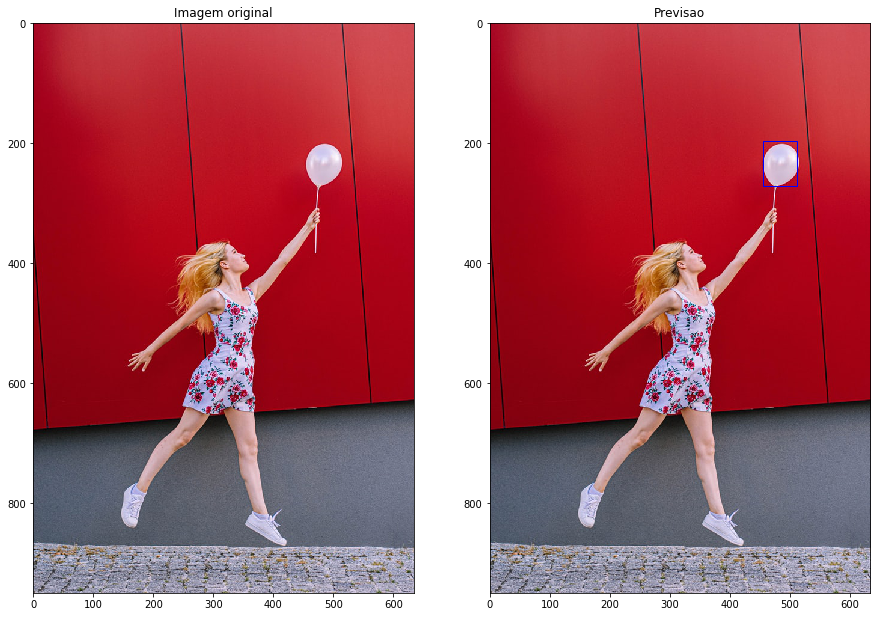

In [8]:
# Mostrando a detecção de objetos funcionando com uma imagem nova aleatória:

from skimage.io import imread
 
class DatasetBaloes(Dataset):

    def carrega_dataset(self, endereco_dataset, subset):
        self.add_class("balloon", 1, "balloon") 
    
        assert subset in ["train", "val"] 
        endereco_dataset = os.path.join(endereco_dataset, subset)

        anotacoes = json.load(open(os.path.join(endereco_dataset, "via_region_data.json"))) 
        anotacoes = list(anotacoes.values())  

        anotacoes = [a for a in anotacoes if a['regions']] 

        for a in anotacoes:
        
            poligonos = [r['shape_attributes'] for r in a['regions'].values()] 

            endereco_imagem = os.path.join(endereco_dataset, a['filename']) 
            imagem = skimage.io.imread(endereco_imagem)
            altura, largura = imagem.shape[:2] 

            self.add_image("balloon", image_id=a['filename'], path=endereco_imagem, width=largura, height=altura, polygons=poligonos)
        
    def load_mask(self, imagem_id):

        informacoes = self.image_info[imagem_id] 
        mascara = np.zeros([informacoes["height"], informacoes["width"], len(informacoes["polygons"])], dtype=np.uint8)
        for i, p in enumerate(informacoes["polygons"]): 
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x']) 
            mascara[rr, cc, i] = 1 

        return mascara, np.ones([mascara.shape[-1]], dtype=np.int32)


# Criando uma classe para as configurações das previsões:
class ConfiguracoesPrevisoes(Config): 
    NAME = "dataset_baloes"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# Criando a função que carrega uma imagem e faz a detecção de objetos:
def plotando_atual_vs_prevista(imagem, modelo, cfg):
    imagem_centrada = mold_image(imagem, cfg) # aplicando centering
    amostra = expand_dims(imagem_centrada, 0) # criando a dimensão extra do batch_size
    dados = modelo.detect(amostra, verbose=0)[0] # fazendo a previsão dessa imagem
    figura = plt.figure(figsize=(15,15)) # tamanho da figura total (irá comportar 2 imagens nesse caso)
    # Criando o subplot para mostrar a imagem atual sem previsão:
    figura.add_subplot(1, 2, 1) # quebra a figura em duas partes nas colunas. Irá colocar a imagem carregada na esquerda.
    plt.imshow(imagem) # mostra a imagem
    plt.title('Imagem original') 
    figura.add_subplot(1, 2, 2) # quebra a figura em duas partes nas colunas. Irá colocar a detecção do modelo na direita.
    plt.imshow(imagem) # mostra a imagem
    plt.title('Previsao')
    eixos = plt.gca()
    # plotando as caixas previstas:
    for caixa in dados['rois']:
        y1, x1, y2, x2 = caixa
        largura, altura = x2 - x1, y2 - y1
        retangulo = Rectangle((x1, y1), largura, altura, fill=False, color='blue')
        eixos.add_patch(retangulo) # adiciona o retângulo previsto pelo modelo na figura
    plt.show()

# Carregando a imagem:
imagem_baloes = imread('/home/natanael/Documents/DidaticaTech/balao.jpeg')

cfg = ConfiguracoesPrevisoes()

modelo = MaskRCNN(mode='inference', model_dir='/home/natanael/Documents/DidaticaTech/balloon_dataset/modelo_testando', config=cfg)
modelo.load_weights('/home/natanael/Documents/DidaticaTech/balloon_dataset/treinando_modelo/baloes20200201T1003/mask_rcnn_baloes_0005.h5', by_name=True)

# Mostrando as previsões da imagem:
plotando_atual_vs_prevista(imagem_baloes, modelo, cfg)

Re-starting from epoch 5


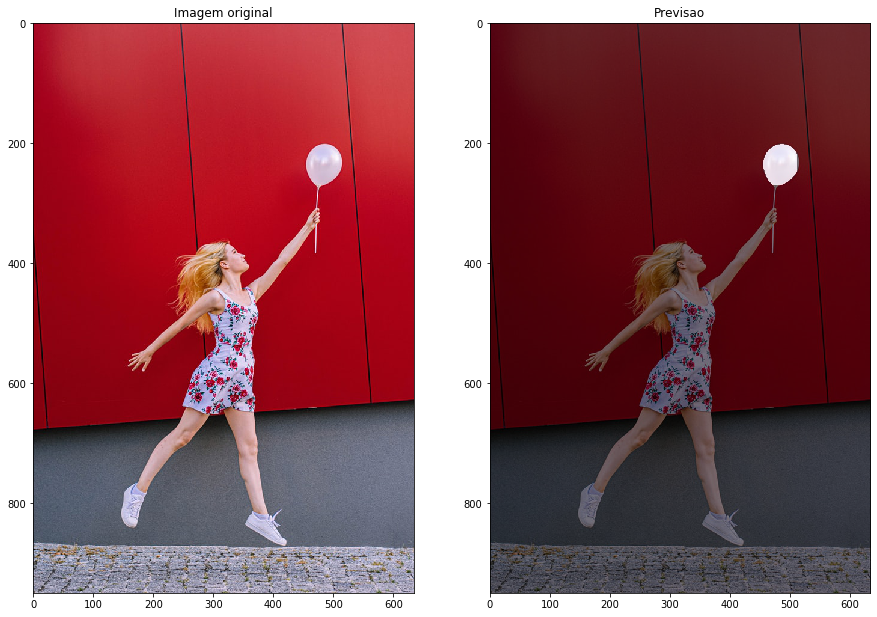

In [9]:
# Mostrando a segmentação de instâncias funcionando com uma imagem nova aleatória

from skimage.io import imread

class DatasetBaloes(Dataset):

    def carrega_dataset(self, endereco_dataset, subset):
        self.add_class("balloon", 1, "balloon") 
    
        assert subset in ["train", "val"] 
        endereco_dataset = os.path.join(endereco_dataset, subset)

        anotacoes = json.load(open(os.path.join(endereco_dataset, "via_region_data.json"))) 
        anotacoes = list(anotacoes.values())  

        anotacoes = [a for a in anotacoes if a['regions']] 

        for a in anotacoes:
        
            poligonos = [r['shape_attributes'] for r in a['regions'].values()] 

            endereco_imagem = os.path.join(endereco_dataset, a['filename']) 
            imagem = skimage.io.imread(endereco_imagem)
            altura, largura = imagem.shape[:2] 

            self.add_image("balloon", image_id=a['filename'], path=endereco_imagem, width=largura, height=altura,
                polygons=poligonos)
        
    def load_mask(self, imagem_id):

        informacoes = self.image_info[imagem_id] 
        mascara = np.zeros([informacoes["height"], informacoes["width"], len(informacoes["polygons"])], dtype=np.uint8)
        for i, p in enumerate(informacoes["polygons"]): 
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x']) 
            mascara[rr, cc, i] = 1 

        return mascara, np.ones([mascara.shape[-1]], dtype=np.int32)

# Criando uma classe para as configurações das previsões:
class ConfiguracoesPrevisoes(Config): 
    NAME = "dataset_baloes"
    NUM_CLASSES = 2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

# Criando a função que carrega uma imagem e faz a segmentação de instância:
def plotando_mascara_atual_vs_prevista(imagem, modelo, cfg):
    imagem_centrada = mold_image(imagem, cfg) # aplicando centering
    amostra = expand_dims(imagem_centrada, 0) # criando a dimensão extra do batch_size
    dados = modelo.detect(amostra, verbose=0)[0] # fazendo a previsão dessa imagem
    figura = plt.figure(figsize=(15,15)) # tamanho da figura total (irá comportar 2 imagens nesse caso)
    # Criando o subplot para mostrar a imagem atual sem previsão:
    figura.add_subplot(1, 2, 1) # quebra a figura em duas partes nas colunas. Irá colocar a imagem carregada na esquerda.
    plt.imshow(imagem) # mostra a imagem
    plt.title('Imagem original') 
    figura.add_subplot(1, 2, 2) # quebra a figura em duas partes nas colunas. Irá colocar a detecção do modelo na direita.
    plt.imshow(imagem) # mostra a imagem
    plt.title('Previsao')
    # plotando as máscaras previstas:
    mascaras_previstas = dados['masks'].astype(int)
    for j in range(mascaras_previstas.shape[2]):
        plt.imshow(mascaras_previstas[:, :, j], cmap='gray', alpha=0.5) # desenha a máscara
    plt.show()

# Carregando a imagem:
imagem_baloes = imread('/home/natanael/Documents/DidaticaTech/balao.jpeg')

cfg = ConfiguracoesPrevisoes()

modelo = MaskRCNN(mode='inference', model_dir='/home/natanael/Documents/DidaticaTech/balloon_dataset/modelo_testando', config=cfg)
modelo.load_weights('/home/natanael/Documents/DidaticaTech/balloon_dataset/treinando_modelo/baloes20200201T1003/mask_rcnn_baloes_0005.h5', by_name=True)

# Mostrando as previsões da imagem:
plotando_mascara_atual_vs_prevista(imagem_baloes, modelo, cfg)